In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import platform
from matplotlib import font_manager, rc

# '-' 기호 보이게 하기
matplotlib.rcParams['axes.unicode_minus'] = False

# 운영 체제마다 한글이 보이게 하는 설정
# 윈도우
if platform.system() == 'Windows':
    path = "c:\Windows\Fonts\malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
# 맥
elif platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic')
# 리눅스
elif platform.system() == 'Linux':
    plt.rc('font', family='NanumBarunGothic')

# 데이터 불러오기

In [5]:
data1 = pd.read_csv('data/fa_weekend_total.csv')
data2 = pd.read_csv('data/cnt_food.csv')
data = pd.merge(data1, data2, on = 'cust', how='left')
data = data.fillna(0)
data

,cust,fa1_rct_n,fa2_rct_n,weekend_ratio,A04
0,M000871427,6.0,9.0,0.454545,0.0
1,M001403108,12.0,12.0,0.360000,0.0
2,M002238144,53.0,99.0,0.421875,56.0
3,M002352655,17.0,14.0,0.347826,3.0
4,M003490042,1.0,2.0,1.000000,0.0
...,...,...,...,...,...
1804,M998129365,1.0,1.0,1.000000,0.0
1805,M998574012,17.0,84.0,0.580645,67.0
1806,M998600186,1.0,1.0,0.000000,0.0
1807,M999153368,9.0,12.0,0.608696,0.0


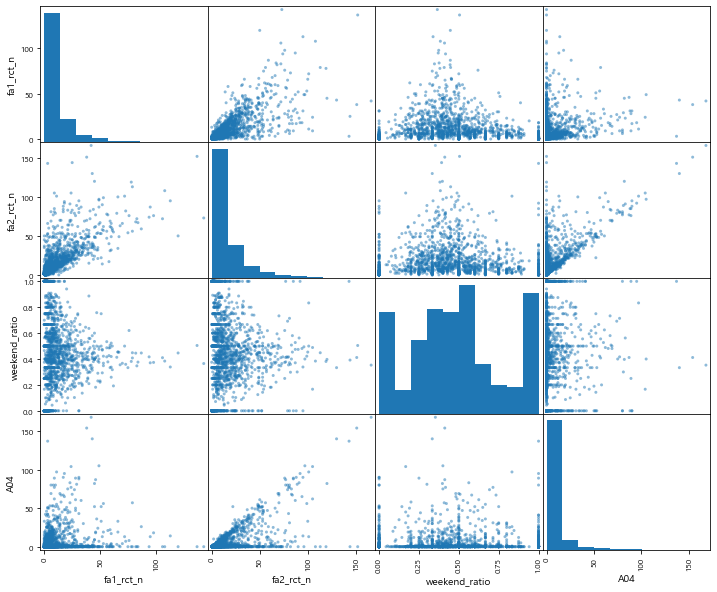

In [15]:
from pandas.plotting import scatter_matrix
cols = ['fa1_rct_n', 'fa2_rct_n', 'weekend_ratio', 'A04']
scatter_matrix(data[cols], figsize=(12,10))
plt.show()

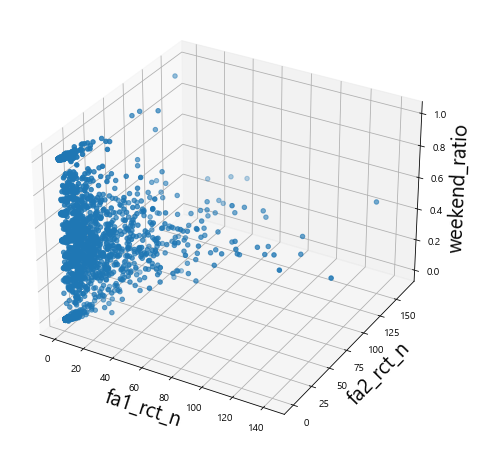

In [16]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
ax.scatter(data1[cols[0]], data1[cols[1]], data1[cols[2]], s=20)
ax.set_xlabel(cols[0], fontsize=20)
ax.set_ylabel(cols[1], fontsize=20)
ax.set_zlabel(cols[2], fontsize=20)
plt.show()

# 이상치 제거

# 군집화

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score

In [17]:
def RunKM(df, n_clusters, columns):
    km = KMeans(n_clusters=n_clusters, random_state=1)
    km.fit(df[columns].values)
    df['clus'] = km.labels_

    score_samples = silhouette_samples(df[columns], df['clus'])
    df['sil_coef'] = score_samples

    return df[['clus']]

In [23]:
def Optimize(df, n_clusters_list):
    fig = plt.figure(figsize=(6*len(n_clusters_list), 16))
    ax = []

    columns = df.columns
    for i, n_clusters in enumerate(n_clusters_list):
        ax.extend([fig.add_subplot(2, len(n_clusters_list), i+1), fig.add_subplot(2, len(n_clusters_list), i+1+len(n_clusters_list), projection='3d')])
        RunKM(df_sc, n_clusters, columns)
        y_lower = 10

        for n in range(n_clusters):
            df_tmp = df[df['clus'] == n]
            sil_coef = df_tmp['sil_coef'].sort_values()
            clus_size = sil_coef.shape[0]
            y_upper = y_lower + clus_size

            ax[2*i].fill_betweenx(np.arange(y_lower, y_upper), 0, sil_coef)
            ax[2*i].text(-0.05, y_lower + 0.5 * clus_size, str(n))

            ax[2*i+1].scatter(df_tmp[columns[0]], df_tmp[columns[1]], df_tmp[columns[2]], label=n)

            y_lower = y_upper + 10
            del df_tmp

        avg_score = silhouette_score(df[columns], df['clus'])
        ax[2*i].axvline(x=avg_score, color="red", linestyle="--")
        ax[2*i].set_title('n_clusters : %d\nsilhouette score : %.3f' % (n_clusters, avg_score))
        
        ax[2*i+1].set_xlabel(cols[0], fontsize=20)
        ax[2*i+1].set_ylabel(cols[1], fontsize=20)
        ax[2*i+1].set_zlabel(cols[2], fontsize=20)
        ax[2*i+1].legend()

    plt.show()

In [24]:
from sklearn.preprocessing import StandardScaler
X_sc = StandardScaler().fit_transform(data[cols].values)
df_sc = pd.DataFrame(X_sc, columns = cols)

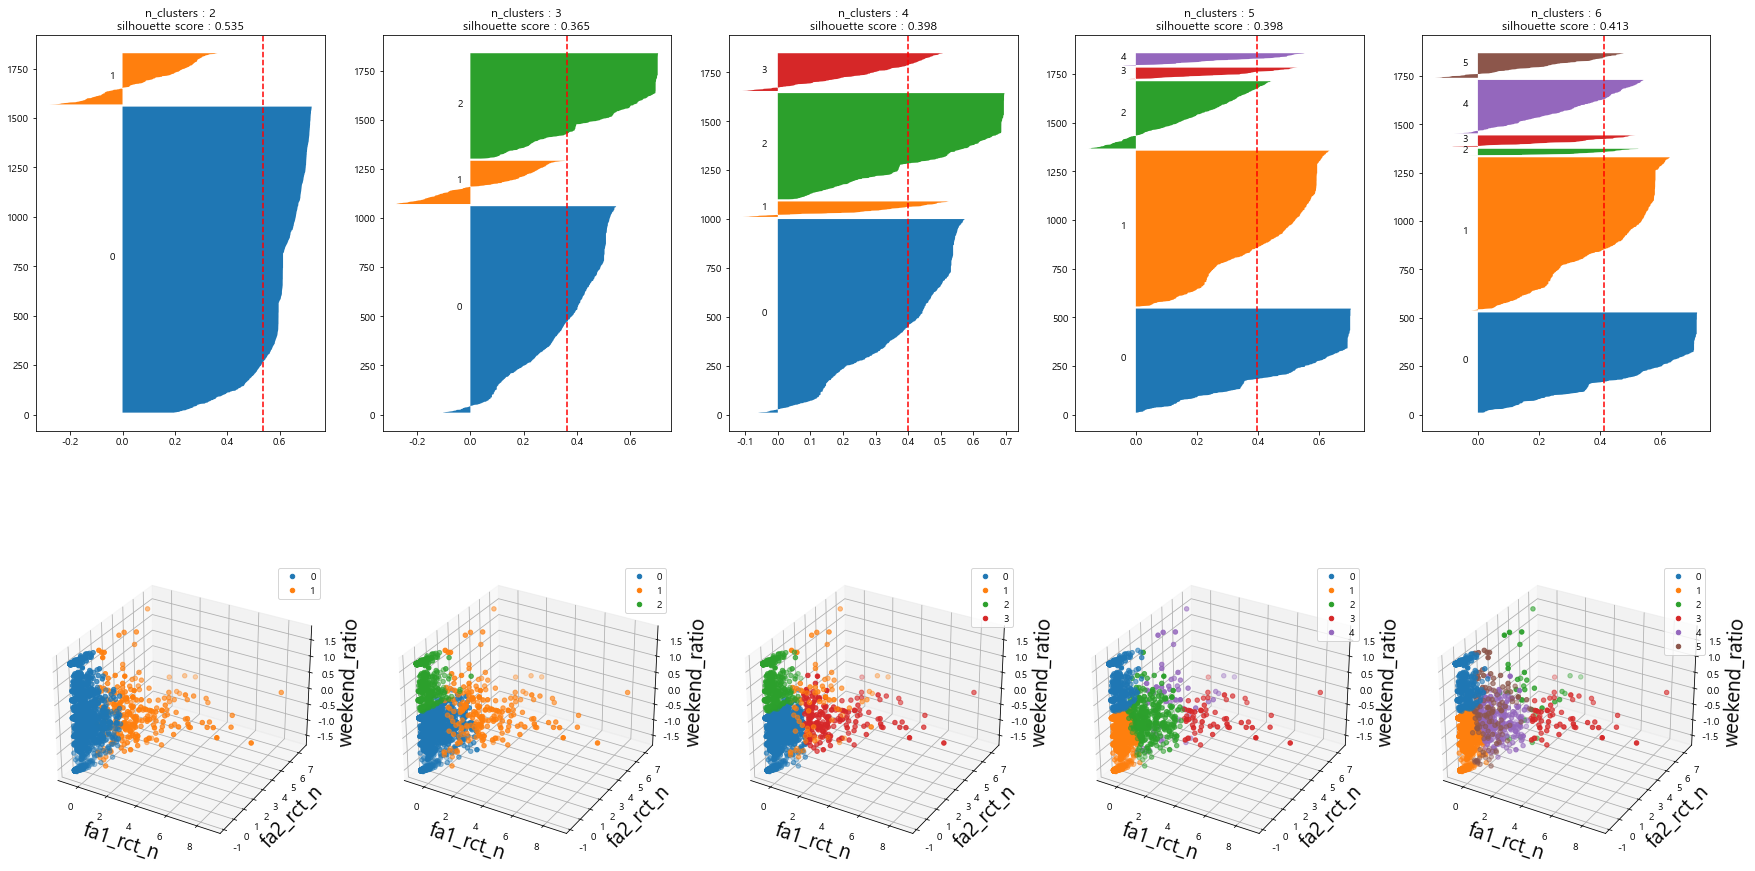

In [25]:
Optimize(df_sc, [i for i in range(2, 7)])

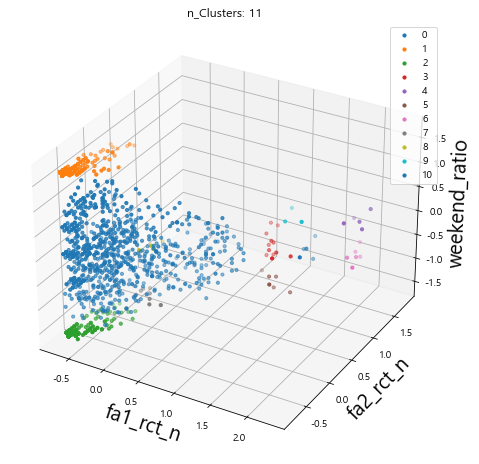

In [34]:
from sklearn.cluster import DBSCAN

X = df_sc.iloc[:, :-2].copy()
db = DBSCAN(eps = 0.24)
db.fit(X.values)
X['clus'] = db.labels_
n_clusters = len(set(X['clus'].unique())-{-1})

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d')
for n in range(n_clusters):
    x = X.loc[X['clus'] == n]
    ax.scatter(x[cols[0]], x[cols[1]], x[cols[2]], s=10, label = n, marker='o', cmap = 'Set1')
    ax.set_xlabel(cols[0], fontsize=20)
    ax.set_ylabel(cols[1], fontsize=20)
    ax.set_zlabel(cols[2], fontsize=20)
    ax.set_title(f'n_Clusters: {n_clusters}')
    ax.legend()
plt.show()

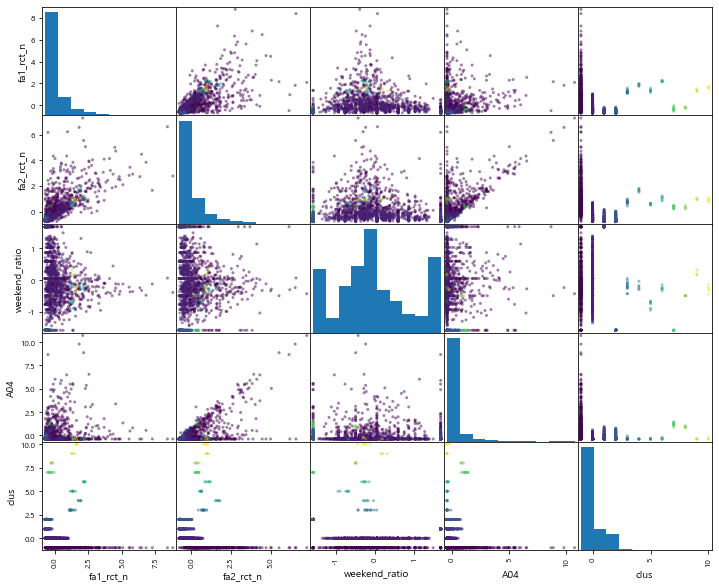

In [35]:
# DBSCAN 결과 분포 시각화
scatter_matrix(X, figsize=(12,10), c = X['clus'])
plt.show()